# Prédiction du taux de mortalité sur le reste du monde et génération de la carte finale

L'objetcif de ce notebook est de fitter le modèle que nous avons retenu sur les pays dont nous ne disposons pas du taux de mortalité et ainsi compléter la carte du monde présentée au début de notre rapport.

In [45]:
# import des librairies 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler; scaler = MinMaxScaler()
from sklearn.model_selection import validation_curve
from sklearn import metrics
from sklearn.dummy import DummyRegressor
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.patches as mpatches
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')
import os
os.chdir("C:/Users/flora_000/Desktop/ENSAE/Projet Python/Data")
os.getcwd()

'C:\\Users\\flora_000\\Desktop\\ENSAE\\Projet Python\\Data'

## 1) On fitte le modèle que nous avons retenu à partir de notre modélisation

Pour rappel, le modèle retenu est la forêt aléatoire pour une régression.

In [46]:
# on importe la base qui a servi pour créer les modèles
data= pd.read_csv('data.csv',delimiter=',',low_memory=False)
print(data.shape)
data.head()

(37264, 58)


,Unnamed: 0,Unnamed: 0.1,Cancer_code,Sex,Age_bucket,Location,Year,Nb_deaths,Country,Age_group,...,EN.ATM.CO2E.LF.KT,EN.ATM.METH.AG.KT.CE,EN.ATM.METH.EG.KT.CE,EN.ATM.NOXE.AG.KT.CE,EN.ATM.NOXE.EG.KT.CE,NY.GDP.TOTL.RT.ZS,EN.ATM.CO2E.KT,EN.ATM.CO2E.PC,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD
0,14648,42136,"C33,C34",1,2,Antigua and Barbuda,2000,0,Antigua and Barbuda,2,...,344.698,23.119577,1.025246,11.202249,2.045597,0.0,344.698,4.439239,7.838379e+08,10094.759065
1,14663,42151,"C33,C34",1,3,Antigua and Barbuda,2000,0,Antigua and Barbuda,3,...,344.698,23.119577,1.025246,11.202249,2.045597,0.0,344.698,4.439239,7.838379e+08,10094.759065
2,14679,42167,"C33,C34",2,3,Antigua and Barbuda,2000,0,Antigua and Barbuda,3,...,344.698,23.119577,1.025246,11.202249,2.045597,0.0,344.698,4.439239,7.838379e+08,10094.759065
3,14694,42182,"C33,C34",1,1,Antigua and Barbuda,2000,0,Antigua and Barbuda,1,...,344.698,23.119577,1.025246,11.202249,2.045597,0.0,344.698,4.439239,7.838379e+08,10094.759065
4,14708,42196,"C33,C34",1,6,Antigua and Barbuda,2000,0,Antigua and Barbuda,6,...,344.698,23.119577,1.025246,11.202249,2.045597,0.0,344.698,4.439239,7.838379e+08,10094.759065


In [47]:
#variable à expliquer : taux de mortalité 
Y = data['Mortality_rate']
print(Y.describe())

#variables explicatives quantitatives
indicators = ['SP.URB.TOTL.IN.ZS',	'SP.URB.GROW',	'SP.POP.GROW',	'SE.PRM.DURS',	'AG.SRF.TOTL.K2',	'SE.PRE.DURS',	'EN.POP.DNST',	'SE.SEC.DURS',	'SP.DYN.CBRT.IN',	'SP.DYN.CDRT.IN',	'NY.ADJ.AEDU.GN.ZS',	'SP.DYN.TFRT.IN',	'SP.ADO.TFRT',	'SP.DYN.LE00.FE.IN',	'SP.DYN.LE00.IN',	'SP.POP.DPND',	'SP.DYN.AMRT.FE',	'SP.DYN.AMRT.MA',	'EN.ATM.NOXE.KT.CE',	'EN.ATM.METH.KT.CE',	'AG.LND.AGRI.K2',	'EN.ATM.GHGO.KT.CE',	'AG.LND.AGRI.ZS',	'AG.PRD.FOOD.XD',	'IT.CEL.SETS',	'AG.PRD.LVSK.XD',	'AG.PRD.CROP.XD',	'IT.MLT.MAIN',	'EN.ATM.GHGT.KT.CE',	'EN.ATM.CO2E.GF.ZS',	'EN.ATM.CO2E.LF.ZS',	'EN.ATM.CO2E.SF.ZS',	'NY.GDP.FRST.RT.ZS',	'NY.GDP.MINR.RT.ZS',	'EN.ATM.CO2E.LF.KT',	'EN.ATM.METH.AG.KT.CE',	'EN.ATM.METH.EG.KT.CE',	'EN.ATM.NOXE.AG.KT.CE',	'EN.ATM.NOXE.EG.KT.CE',	'NY.GDP.TOTL.RT.ZS',	'EN.ATM.CO2E.KT',	'EN.ATM.CO2E.PC',	'NY.GDP.MKTP.CD',	'NY.GDP.PCAP.CD']          

#variables explicatives catégorielles : sex, tranche d'age, pays
data["Country_code"] = data["Country"].astype('category').cat.codes
data["Sex"] = data["Sex"].astype('category')
data["Age_bucket"] = data["Age_bucket"].astype('category')

# Normalisation des variables explicatives
X = data[indicators + ['Sex', 'Age_bucket', 'Year', 'Country_code']]
X_scaled = scaler.fit_transform(X)

# on constitut nos deux échantillons "train" et "test"
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled , Y, random_state = 0, test_size=0.3)

count    37264.000000
mean        50.884518
std        132.585822
min          0.000000
25%          0.000000
50%          1.260432
75%         32.844219
max       1428.571429
Name: Mortality_rate, dtype: float64


In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [49]:
%%time
# le modèle final est le suivant :

# Etape 1 : définition des paramètres
RF = RandomForestRegressor(n_estimators=10,max_depth=19,max_features=24)

# Etape 2 : apprentissage
RF = RF.fit(X_train, Y_train)

# Etape 3 : prédiction
Y_pred_train = RF.predict(X_train)
Y_pred_test  = RF.predict(X_test)

# Etape 4 : evaluation  (on calcule l'erreur)

# on calcule l'erreur (RMSE)
err_train = metrics.mean_squared_error(Y_pred_train, Y_train)**0.5
err_test = metrics.mean_squared_error(Y_pred_test, Y_test)**0.5
print("RMSE_train", err_train)
print("RMSE_test", err_test)

# R2
R2_train = RF.score(X_train , Y_train)
R2_test = RF.score(X_test, Y_test)
print("R2_train",R2_train)
print("R2_test",R2_test)

RMSE_train 12.7871539435
RMSE_test 31.1045022888
R2_train 0.990612798713
R2_test 0.946104143156
Wall time: 8.67 s


In [50]:
# résultat sut la base de test

# taux de mortalité observé
print("Minimum de la base test :", Y_test.min())
print("Maximum de la base test :", Y_test.max())
print("Moyenne de la base test :", Y_test.mean())
print("Médiane de la base test :", Y_test.median())
print("Ecart-type de la base test :", Y_test.std())

# taux de mortalité prédit
print("Minimum de la base test :", Y_pred_test.min())
print("Maximum de la base test :", Y_pred_test.max())
print("Moyenne de la base test :", Y_pred_test.mean())
print("Médiane de la base test :", np.median(Y_pred_test))
print("Ecart-type de la base test :", Y_pred_test.std())

Minimum de la base test : 0.0
Maximum de la base test : 1341.35853094
Moyenne de la base test : 51.58598592286612
Médiane de la base test : 1.3077170463979937
Ecart-type de la base test : 133.98771776749388
Minimum de la base test : 0.0
Maximum de la base test : 1289.95956609
Moyenne de la base test : 51.5923382933
Médiane de la base test : 2.22695241593
Ecart-type de la base test : 130.270450884


## 2) On génère une base avec tous les pays présents et on lui applique le modèle

# !!! voir avec ana s'il elle peut mettre le code qui a permi de générer la base de donnée pour la carte finale ou expliquer la démarche effectué pour obtenir cette base

In [51]:
# on importe la base de données qui contient tous les pays 
df_pred = pd.read_csv('data_pred_wb.csv', sep=',', low_memory=False)
df_pred = df_pred[df_pred['Age_group'] !='80UP']
print(df_pred.shape)
df_pred.head()

(97728, 52)


,Unnamed: 0,Country,Year,Age_group,Sex,Population,area,year,SP.URB.TOTL.IN.ZS,SP.URB.GROW,...,EN.ATM.CO2E.LF.KT,EN.ATM.METH.AG.KT.CE,EN.ATM.METH.EG.KT.CE,EN.ATM.NOXE.AG.KT.CE,EN.ATM.NOXE.EG.KT.CE,NY.GDP.TOTL.RT.ZS,EN.ATM.CO2E.KT,EN.ATM.CO2E.PC,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD
0,0,Aruba,2000,1,2,3413.0,Aruba,2000,46.717,1.187344,...,2321.211,0.800714,1.030635,0.746749,1.329305,0.000703,2321.211,25.547679,1.873453e+09,20619.56585
1,1,Aruba,2000,1,1,3565.0,Aruba,2000,46.717,1.187344,...,2321.211,0.800714,1.030635,0.746749,1.329305,0.000703,2321.211,25.547679,1.873453e+09,20619.56585
2,2,Aruba,2000,2,2,3598.0,Aruba,2000,46.717,1.187344,...,2321.211,0.800714,1.030635,0.746749,1.329305,0.000703,2321.211,25.547679,1.873453e+09,20619.56585
3,3,Aruba,2000,2,1,3714.0,Aruba,2000,46.717,1.187344,...,2321.211,0.800714,1.030635,0.746749,1.329305,0.000703,2321.211,25.547679,1.873453e+09,20619.56585
4,4,Aruba,2000,3,2,3375.0,Aruba,2000,46.717,1.187344,...,2321.211,0.800714,1.030635,0.746749,1.329305,0.000703,2321.211,25.547679,1.873453e+09,20619.56585


In [52]:
#variables explicatives quantitatives
indicators = ['SP.URB.TOTL.IN.ZS',	'SP.URB.GROW',	'SP.POP.GROW',	'SE.PRM.DURS',	'AG.SRF.TOTL.K2',	'SE.PRE.DURS',	'EN.POP.DNST',	'SE.SEC.DURS',	'SP.DYN.CBRT.IN',	'SP.DYN.CDRT.IN',	'NY.ADJ.AEDU.GN.ZS',	'SP.DYN.TFRT.IN',	'SP.ADO.TFRT',	'SP.DYN.LE00.FE.IN',	'SP.DYN.LE00.IN',	'SP.POP.DPND',	'SP.DYN.AMRT.FE',	'SP.DYN.AMRT.MA',	'EN.ATM.NOXE.KT.CE',	'EN.ATM.METH.KT.CE',	'AG.LND.AGRI.K2',	'EN.ATM.GHGO.KT.CE',	'AG.LND.AGRI.ZS',	'AG.PRD.FOOD.XD',	'IT.CEL.SETS',	'AG.PRD.LVSK.XD',	'AG.PRD.CROP.XD',	'IT.MLT.MAIN',	'EN.ATM.GHGT.KT.CE',	'EN.ATM.CO2E.GF.ZS',	'EN.ATM.CO2E.LF.ZS',	'EN.ATM.CO2E.SF.ZS',	'NY.GDP.FRST.RT.ZS',	'NY.GDP.MINR.RT.ZS',	'EN.ATM.CO2E.LF.KT',	'EN.ATM.METH.AG.KT.CE',	'EN.ATM.METH.EG.KT.CE',	'EN.ATM.NOXE.AG.KT.CE',	'EN.ATM.NOXE.EG.KT.CE',	'NY.GDP.TOTL.RT.ZS',	'EN.ATM.CO2E.KT',	'EN.ATM.CO2E.PC',	'NY.GDP.MKTP.CD',	'NY.GDP.PCAP.CD']          

#variables explicatives catégorielles : sex, tranche d'age, pays
df_pred["Country_code"] = df_pred["Country"].astype('category').cat.codes
df_pred["Sex"] = df_pred["Sex"].astype('category')
df_pred["Age_group"] = df_pred["Age_group"].astype('category')

# Normalisation des variables explicatives
X_pred = df_pred[indicators + ['Sex', 'Age_group', 'Year', 'Country_code']]
X_pred_scaled = scaler.fit_transform(X_pred)

In [53]:
# on applique le modèle retenu sur cette base
Y_pred  = RF.predict(X_pred_scaled )

In [54]:
# taux de mortalité observé
print(Y.describe())

# taux de mortalité prédit
print("Minimum :", Y_pred.min())
print("Maximum :", Y_pred.max())
print("Moyenne :", Y_pred.mean())
print("Médiane :", np.median(Y_pred))
print("Ecart-type :", Y_pred.std())

# les résultats ne sont pas terribles

count    37264.000000
mean        50.884518
std        132.585822
min          0.000000
25%          0.000000
50%          1.260432
75%         32.844219
max       1428.571429
Name: Mortality_rate, dtype: float64
Minimum : 0.0
Maximum : 1045.91342407
Moyenne : 43.9420499225
Médiane : 4.14544837357
Ecart-type : 104.930470613


In [55]:
# on ajoute le taux de mortalité prédit à la base de donnée
df_pred['Pred_Mortality_rate'] = Y_pred
df_pred.describe()

,Unnamed: 0,Year,Population,year,SP.URB.TOTL.IN.ZS,SP.URB.GROW,SP.POP.GROW,SE.PRM.DURS,AG.SRF.TOTL.K2,SE.PRE.DURS,...,EN.ATM.METH.EG.KT.CE,EN.ATM.NOXE.AG.KT.CE,EN.ATM.NOXE.EG.KT.CE,NY.GDP.TOTL.RT.ZS,EN.ATM.CO2E.KT,EN.ATM.CO2E.PC,NY.GDP.MKTP.CD,NY.GDP.PCAP.CD,Country_code,Pred_Mortality_rate
count,97728.000000,97728.000000,9.772800e+04,97728.000000,97728.000000,97728.000000,97728.000000,97728.000000,9.772800e+04,97728.000000,...,97728.000000,97728.000000,97728.000000,97728.000000,9.772800e+04,97728.000000,9.772800e+04,97728.000000,97728.000000,97728.000000
mean,51916.500000,2007.494434,1.080234e+06,2007.494434,55.268336,2.176262,1.500062,5.696136,7.190571e+05,2.728880,...,13672.347720,10606.256489,1403.518898,8.341714,1.656185e+05,4.734159,3.021664e+11,11145.417518,96.369352,43.942050
std,29975.024451,4.608016,4.550676e+06,4.608016,23.641738,2.025738,1.540600,0.890545,1.947163e+06,0.768471,...,57079.819034,33705.018703,6444.568869,12.759579,7.107065e+05,6.674683,1.239521e+12,16801.852591,55.909978,104.931007
min,0.000000,2000.000000,1.720000e+02,2000.000000,8.246000,-3.462541,-4.075386,3.000000,2.000000e+01,1.000000,...,0.000000,0.000000,0.000000,0.000000,2.566900e+01,0.016908,6.310127e+07,106.016975,0.000000,0.000000
25%,25957.750000,2003.000000,4.010731e+04,2003.000000,35.591000,0.736963,0.491430,5.000000,2.634000e+04,2.000000,...,261.712171,335.672505,40.070513,0.411516,2.119526e+03,0.584684,4.521425e+09,1071.323339,47.000000,0.145406
50%,51916.500000,2007.000000,1.709325e+05,2007.000000,55.275500,1.972867,1.352793,6.000000,1.303700e+05,3.000000,...,1399.075319,2187.493982,164.153208,2.494133,1.152171e+04,2.273160,1.947205e+10,3772.105302,97.000000,4.145448
75%,77875.250000,2011.000000,6.414690e+05,2011.000000,74.172000,3.424974,2.369273,6.000000,5.490870e+05,3.000000,...,6899.189540,7168.199254,611.034410,10.768693,6.691175e+04,6.462447,1.292501e+11,13342.084998,145.000000,37.173907
max,103833.000000,2015.000000,6.844154e+07,2015.000000,100.000000,17.899614,17.624770,8.000000,1.709825e+07,5.000000,...,738366.843413,375435.620570,82671.322877,89.166112,1.024946e+07,67.452198,1.803665e+13,117507.808593,192.000000,1045.913424


## 3) On représente le taux de mortalité prédit par pays

In [56]:
# on multiplie le taux de mortalité prédit par la population
# car ce n'est pas correct de faire la moyenne d'une moyenne pour obtenir le taux de mortalité prédit par pays
df_pred['Pred_Nb_deaths'] = df_pred['Pred_Mortality_rate'] * df_pred['Population']

# On calcule le nombre de morts par pays
Nb_deaths_by_country = df_pred.groupby(['Country'])['Pred_Nb_deaths'].sum()

# On calcule la population par pays
Pop_by_country = df_pred.groupby(['Country'])['Population'].sum()

# On met les deux vecteurs dans un dataframe
df_TxMortbyC = pd.DataFrame({'Country':Nb_deaths_by_country.index, 'Pred_Nb_deaths':Nb_deaths_by_country.values, 'Population':Pop_by_country.values})

# On calcule taux de mortalité prédit
df_TxMortbyC['Pred_Mortality_rate'] = df_TxMortbyC['Pred_Nb_deaths'] / df_TxMortbyC['Population'] 
df_TxMortbyC.tail(50)

,Country,Population,Pred_Nb_deaths,Pred_Mortality_rate
143,Rwanda,1.548652e+08,7.875800e+08,5.085585
144,Samoa,2.906257e+06,2.603482e+07,8.958198
145,Sao Tome and Principe,2.580576e+06,1.056823e+07,4.095298
146,Saudi Arabia,4.209301e+08,2.010741e+09,4.776901
147,Senegal,1.950328e+08,6.915923e+08,3.546031
148,Serbia,1.143307e+08,6.208354e+09,54.301722
149,Seychelles,1.354591e+06,2.873630e+07,21.214006
150,Sierra Leone,8.564952e+07,3.872300e+08,4.521100
151,Singapore,7.432860e+07,1.725376e+09,23.212812
152,Slovak Republic,8.399482e+07,3.122885e+09,37.179498


In [57]:
df_TxMortbyC.describe()

,Population,Pred_Nb_deaths,Pred_Mortality_rate
count,1.930000e+02,1.930000e+02,193.000000
mean,5.469903e+08,1.157799e+10,19.275841
std,2.083059e+09,4.981942e+10,16.804607
min,1.672010e+05,4.781152e+06,2.803238
25%,3.139489e+07,3.091325e+08,5.883120
50%,1.138730e+08,1.261608e+09,10.875222
75%,3.640608e+08,5.643760e+09,29.732226
max,2.084624e+10,5.724086e+11,62.880555


In [58]:
# on applique les mêmes quantiles que la première carte

# tranche1 : du min au quantile à 25% 
df_TxMortbyC.loc[(df_TxMortbyC["Pred_Mortality_rate"] <=5.514458) , "Group_Tx_Mortality"] = 1
# tranche2 : du quantile à 25% au quantile à 50%
df_TxMortbyC.loc[ (df_TxMortbyC["Pred_Mortality_rate"] > 5.514458) &(df_TxMortbyC["Pred_Mortality_rate"] <= 17.787761) , "Group_Tx_Mortality"] = 2
# tranche3 : du quantile à 50% au quantile à 75%
df_TxMortbyC.loc[ (df_TxMortbyC["Pred_Mortality_rate"] > 17.787761) &(df_TxMortbyC["Pred_Mortality_rate"] <= 44.570389) , "Group_Tx_Mortality"] = 3
# tranche4 : du quantile à 75% au quantile au max.
df_TxMortbyC.loc[ (df_TxMortbyC["Pred_Mortality_rate"] > 44.570389)  , "Group_Tx_Mortality"] = 4

df_TxMortbyC.head()

,Country,Population,Pred_Nb_deaths,Pred_Mortality_rate,Group_Tx_Mortality
0,Afghanistan,4.172698e+08,2.108272e+09,5.052539,1.0
1,Albania,4.672944e+07,1.240666e+09,26.549980,3.0
2,Algeria,5.534735e+08,6.025060e+09,10.885906,2.0
3,Angola,3.144611e+08,1.158299e+09,3.683440,1.0
4,Antigua and Barbuda,1.334318e+06,2.501365e+07,18.746397,3.0


## On affiche à présent le taux de mortalité prédit sur la carte du monde

In [59]:
# on renomme certains pays de notre base pour fusionner avec la librairie cartopy
df_TxMortbyC.replace(['Venezuela, RB', 'Congo, Rep.', 'Congo, Dem. Rep.', 'Egypt, Arab Rep.', 'Iran, Islamic Rep.', 
                      'Yemen, Rep.',"Cote d'Ivoire","Korea, Rep.","Korea, Dem. People’s Rep."], 
                     ['Venezuela', 'Republic of the Congo', 'Democratic Republic of the Congo','Egypt', 'Iran', 
                      'Yemen',"Côte d'Ivoire","Republic of Korea","Dem. Rep. Korea"], inplace=True)

In [60]:
# On définit nos classes  
Classe = df_TxMortbyC['Country'].groupby(df_TxMortbyC['Group_Tx_Mortality']) 
# tranche 1
low = [x[:] for x in list(Classe)[0][1]] #get country codes in a list for group 0 - High income
# tranche 2
middle_low = [x[:] for x in list(Classe)[1][1]]
# tranche 3 
middle_high = [x[:] for x in list(Classe)[2][1]]
# tranche 4
high = [x[:] for x in list(Classe)[3][1]]

<IPython.core.display.Javascript object>


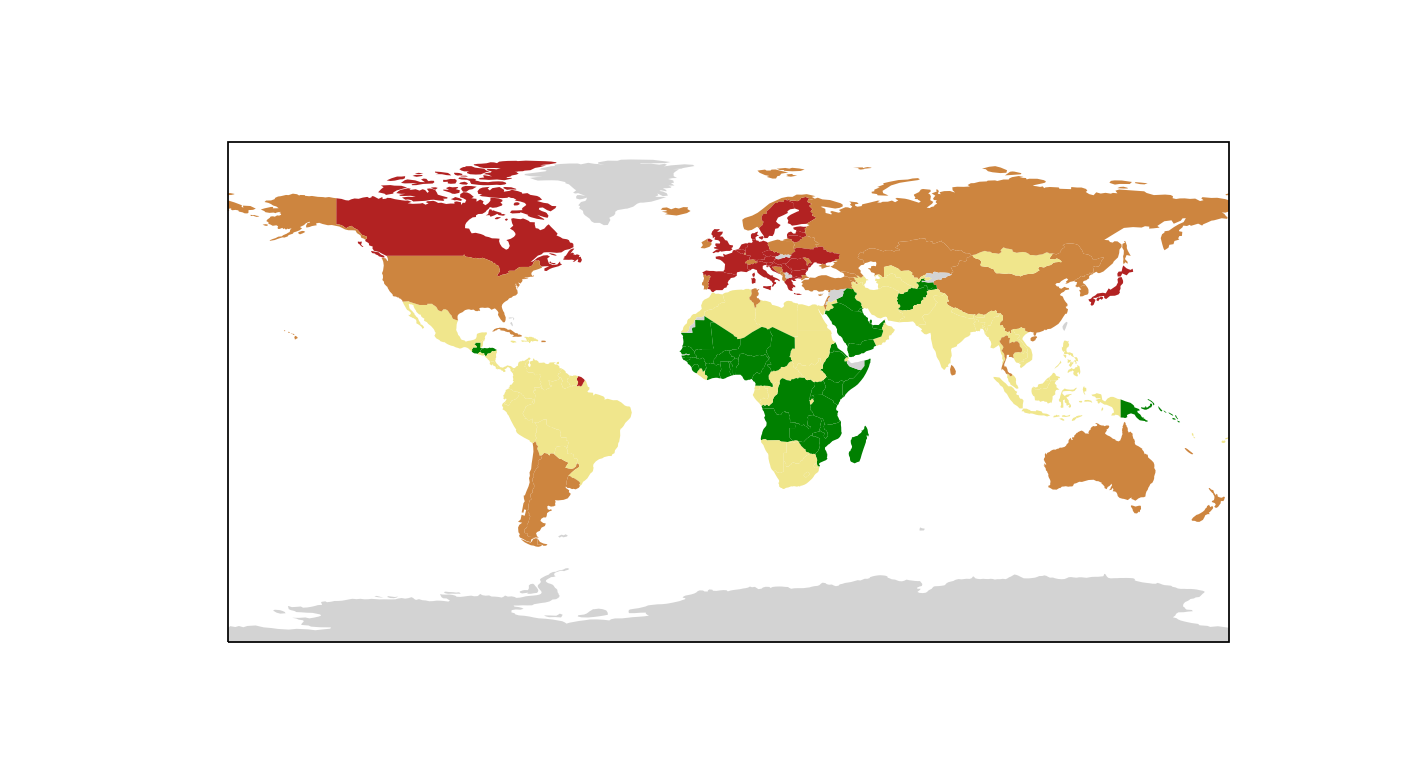

In [61]:
import matplotlib.patches as mpatches

# Affichage de la carte du monde
plt.figure() #size of figure
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m',category='cultural', name=shapename)
ax = plt.axes(projection=ccrs.PlateCarree())
countries = shpreader.Reader(countries_shp).records()


for country in countries:
    #print(country.attributes['FORMAL_EN'])
    if country.attributes['NAME_LONG'] in low:
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor='green')
    
    elif country.attributes['NAME_LONG'] in middle_low:
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor='khaki')      

    elif country.attributes['NAME_LONG'] in middle_high:
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor='peru')   
        
    elif country.attributes['NAME_LONG'] in high:
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor='firebrick')
    else:
        ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          facecolor='lightgrey')

plt.show()

In [22]:
# on peut changer les couleurs : http://www.python-simple.com/img/img38.png

<IPython.core.display.Javascript object>


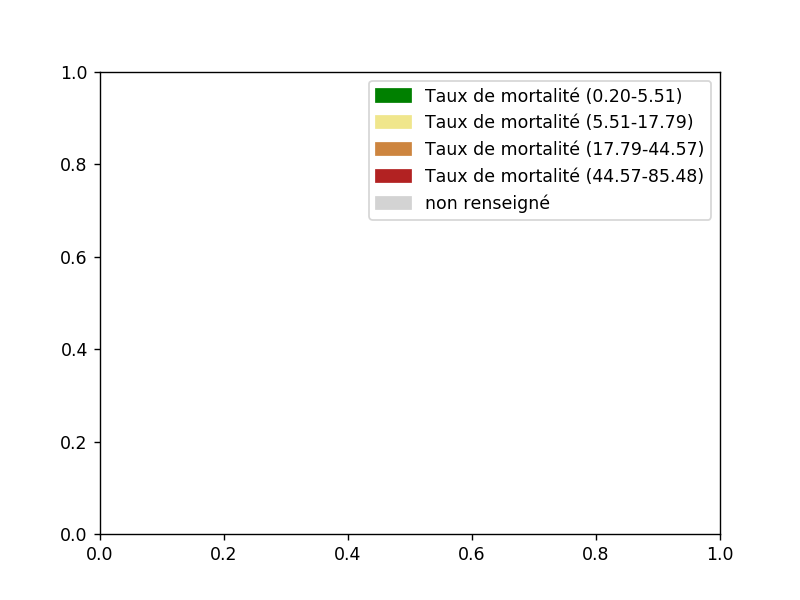

In [20]:
# on affiche la légende

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

low = mpatches.Patch(color='green', label='Taux de mortalité (0.20-5.51)')
middle_low = mpatches.Patch(color='khaki', label='Taux de mortalité (5.51-17.79)')
middle_high = mpatches.Patch(color='peru', label='Taux de mortalité (17.79-44.57)')
high = mpatches.Patch(color='firebrick', label='Taux de mortalité (44.57-85.48)')
na = mpatches.Patch(color='lightgrey', label='non renseigné')
plt.legend(handles=[low,middle_low,middle_high,high,na])

plt.show()

Les pays suivants ne sont pas présents dans la base data_pred_wb : Venezuela, RB; Congo, Rep.; Egypt, Arab Rep.; Iran, Islamic Rep.; Yemen, Rep.; Greenland.